# BOAR with SIMsalabim
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with drift-diffusion modeling to fit of 'fake' JV curves.  
To perform the drift-diffusion simulation in the background we use the open-source program [SIMsalabim](https://github.com/kostergroup/SIMsalabim), for more information about SIMsalabim please check the [GitHub repository](https://github.com/kostergroup/SIMsalabim)  
Make sure you have SIMsalabim installed before running this Notebook.  
Here we are fitting some 'fake' data that are generated by the drift-diffusion model.

In [1]:
# Activate matplotlib widgets
%matplotlib inline
%matplotlib widget 

# Import libraries
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar package
from boar import *


In [2]:
Student_number = 12 # change this to your student number
Case_number = 4 # change this to the case number you are working on

In [3]:
# Define path to SIMsalabim
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '..')) # path to the parent directory
path2simu = os.path.join(parent_dir, 'SIMsalabim','SimSS') # path to the SIMsalabim directory
# Directory where the results are stored
res_dir = os.path.join(curr_dir,'temp') # absolute path to the results directory (note that this will be delete in the last cell of this notebook)
dev_par_file = os.path.join(parent_dir,'Data_2_fit',f'Case_{Case_number}',f'Case_{Case_number}_device_parameters.txt') # absolute path to the device parameter file (here we use a fake OPV device for illustration purposes)

### Define the free parameters to be optimized

In [4]:
# define Fitparameters
True_params = {'kdirect':5e-18,'mun_0':2e-8,'mup_0':8e-8,'Nc':5e26,'Gehp':1.28e28,'W_L':0,'Rseries':3e-4,'Bulk_tr':1e20}
params = []

Gehp = Fitparam(name = 'Gehp', val = True_params['Gehp'] , relRange = 1.5, lims=[1.25e28,1.3e28],range_type='log',optim_type='lin',display_name='G$_{ehp}$',unit='m$^{-3}$ s$^{-1}$')
params.append(Gehp)

Nc = Fitparam(name = 'Nc', val = True_params['Nc'] , relRange = 1.5, lims=[1e26,5e26],range_type='log',optim_type='lin',display_name='N$_{c}$',unit='m$^{-3}$')
params.append(Nc)

Bulk_tr = Fitparam(name = 'Bulk_tr', val = True_params['Bulk_tr'] , relRange = 1.5, lims=[1e17,1e21],range_type='log',optim_type='log',display_name='Bulk tr',unit='m$^{-3}$')
params.append(Bulk_tr)

params_true = copy.deepcopy(params)


### Check the structure of the device for SIMsalabim
Here we check the structure of the device for SIMsalabim and you can adjust the parameters if needed.

For example, if you want to change the thickness of the active layer (AL) you can do this by changing the value of the variable `L` in the cell below.
To do so you need to update the value of the variable ParFileDic['L'] and set MakeUpdate to True.

By convention LTL is the ETL and RTL is the HTL.\
Note that L is the **total** thickness of the ETL, HTL and active layer, so if you want to change the thickness of the active layer you need to subtract the thickness of the ETL and HTL from the total thickness. 
Such that:

$L_{AL} = L - L_{LTL} - L_{RTL}$

To check the name of the parameters in SIMsalabim please refer to the [SIMsalabim documentation](https://github.com/kostergroup/SIMsalabim).

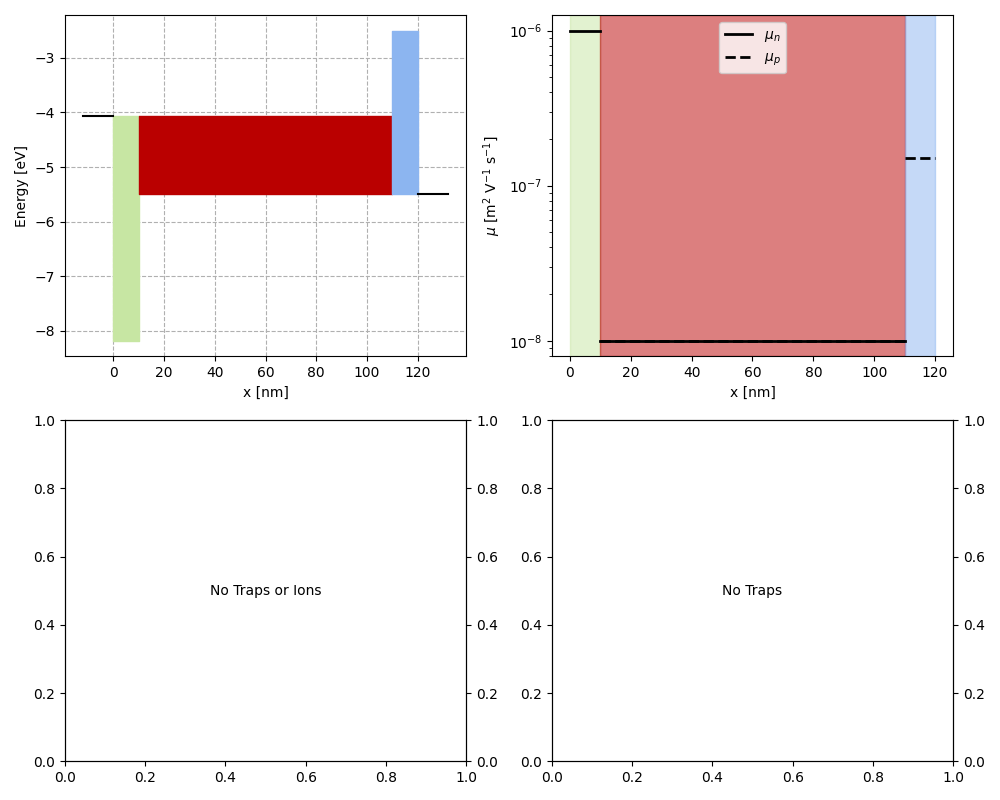

In [5]:
# Vizualize the stack defined for the simulation
from boar.SIMsalabim_utils.PlotInputPar import *

# Load Device parameters file and update parameters
ParFileDic = ReadParameterFile(dev_par_file) # read the parameters from the file

# Visualize the parameters
fig, axs = plt.subplots(2,2,figsize = (10,8))
plot_input_nrj_diag(ParFileDic,ax=axs[0, 0])
plot_input_mob(ParFileDic,ax=axs[0, 1])
plot_input_dens(ParFileDic,ax=axs[1, 0])
plot_input_SRH_lifetime(ParFileDic,ax=axs[1, 1],y_unit='ns',y2_unit='cm')
plt.tight_layout()
plt.show()

### Plot data to fit


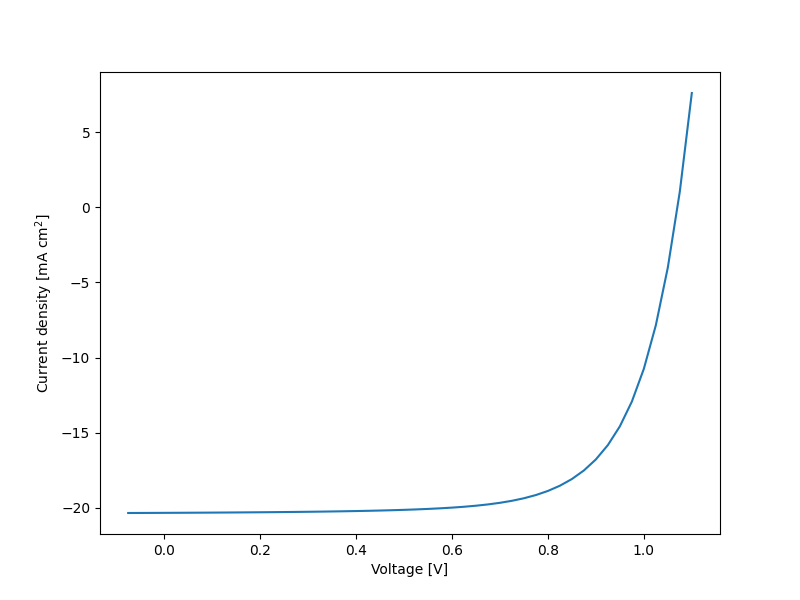

In [6]:
# import the data to fit
data2fit = pd.read_csv(os.path.join(parent_dir,'Data_2_fit',f'Case_{Case_number}',f'Case_{Case_number}_student_{Student_number}.txt'),delim_whitespace=True)

# Visualize the data
plt.figure(figsize=(8,6))
plt.plot(data2fit['Vext'],data2fit['Jext']/10)
plt.xlabel('Voltage [V]')
plt.ylabel('Current density [mA cm$^2$]')

Gfrac = np.ones(len(data2fit['Vext']))
X = np.asarray(data2fit['Vext'].values)
# concatenate the Gfrac in the X array
X = np.vstack((X,Gfrac)).T
y = np.asarray(data2fit['Jext'].values)

### Start the optimization

Scaling runs for target 0:   0%|          | 0/3 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/10 [00:00<?, ?it/s]

Initial points done in 15.38 s
Starting with BO


BO runs:   0%|          | 0/10 [00:00<?, ?it/s]

BO done in 41.53 s
Ground truth minimum at: [1.3, 1.5657351694170296, 19.02801396235139] with function value: 0.033840700008849534
Minimum of surrogate function: [1.3, 1.581063972939788, 19.03230664645185] with function value 0.03388219699982464
Sampling for posterior distribution done in  0.04455924034118652 s


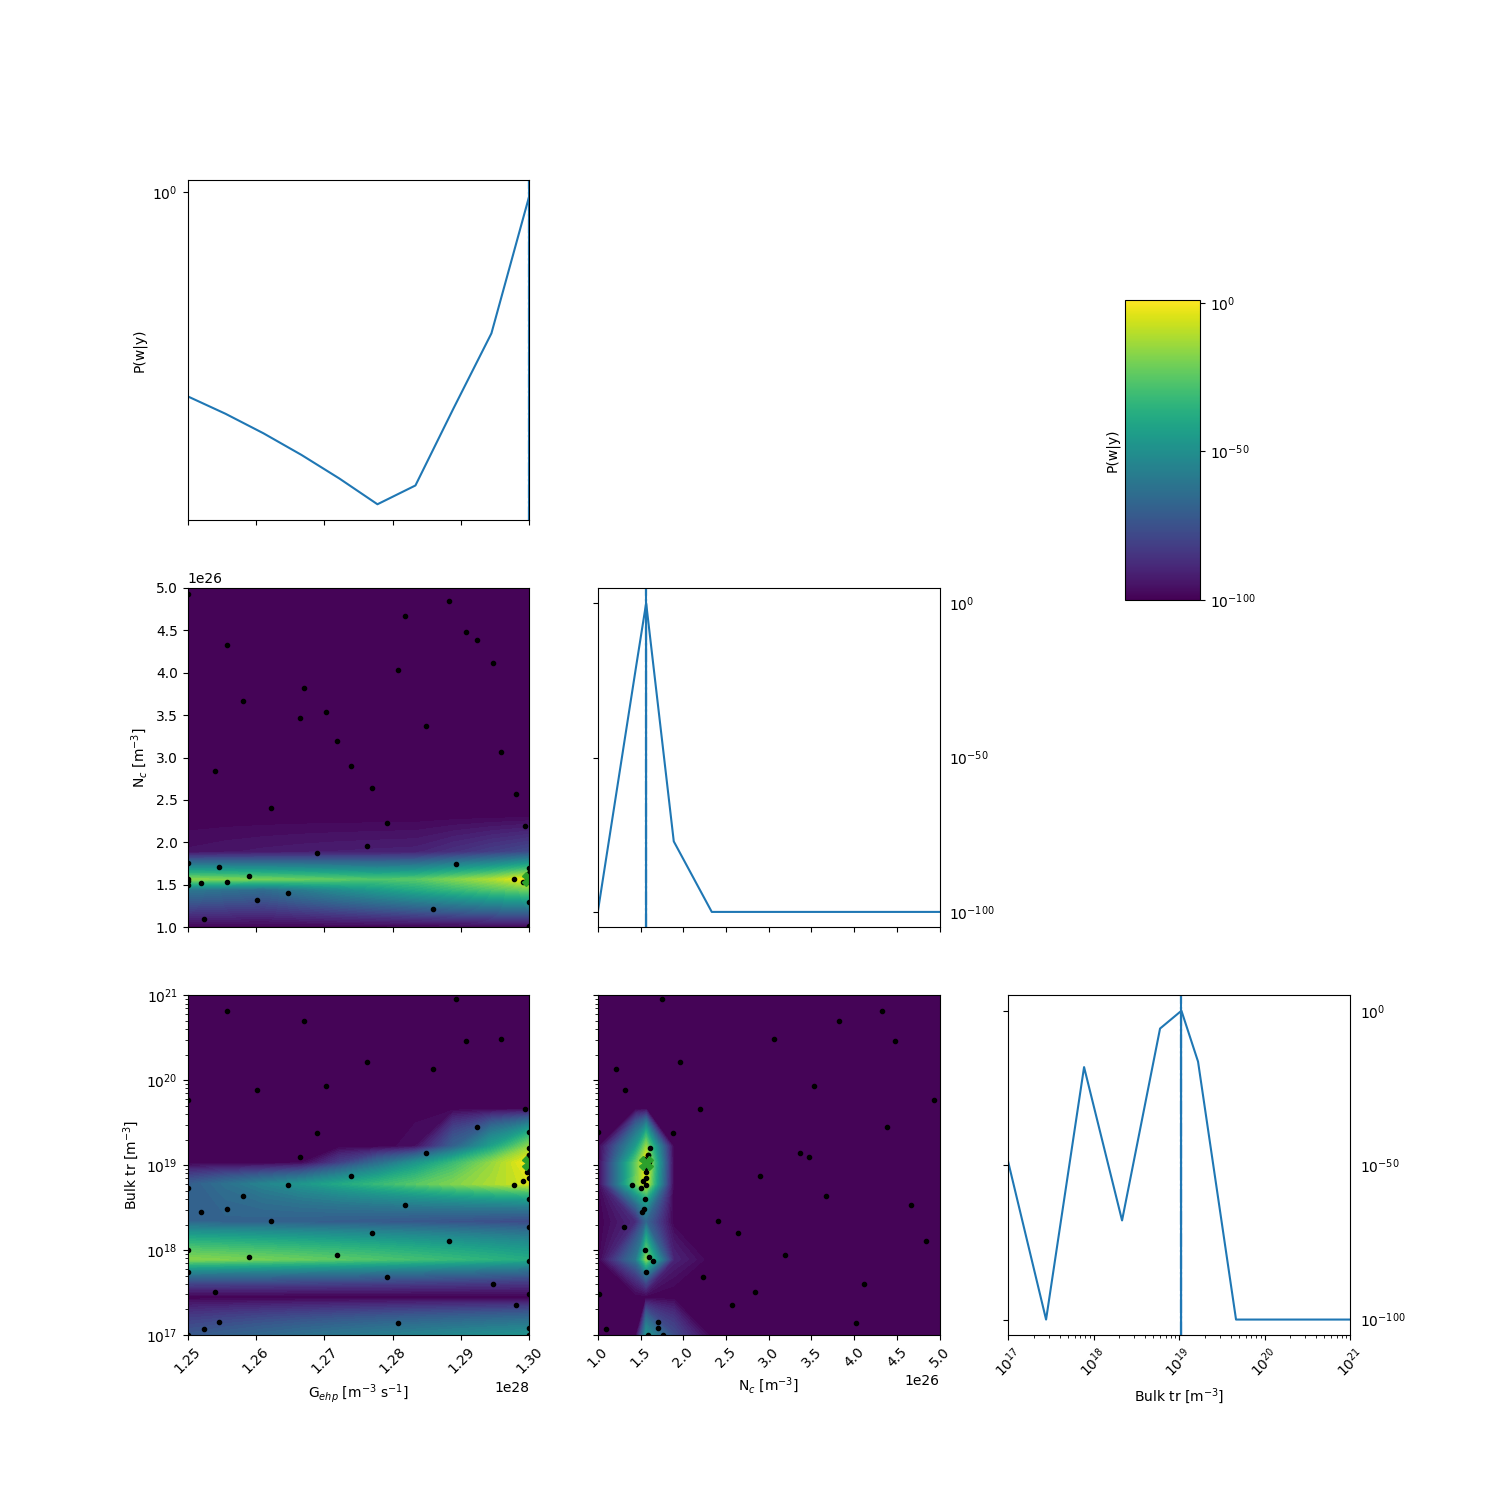

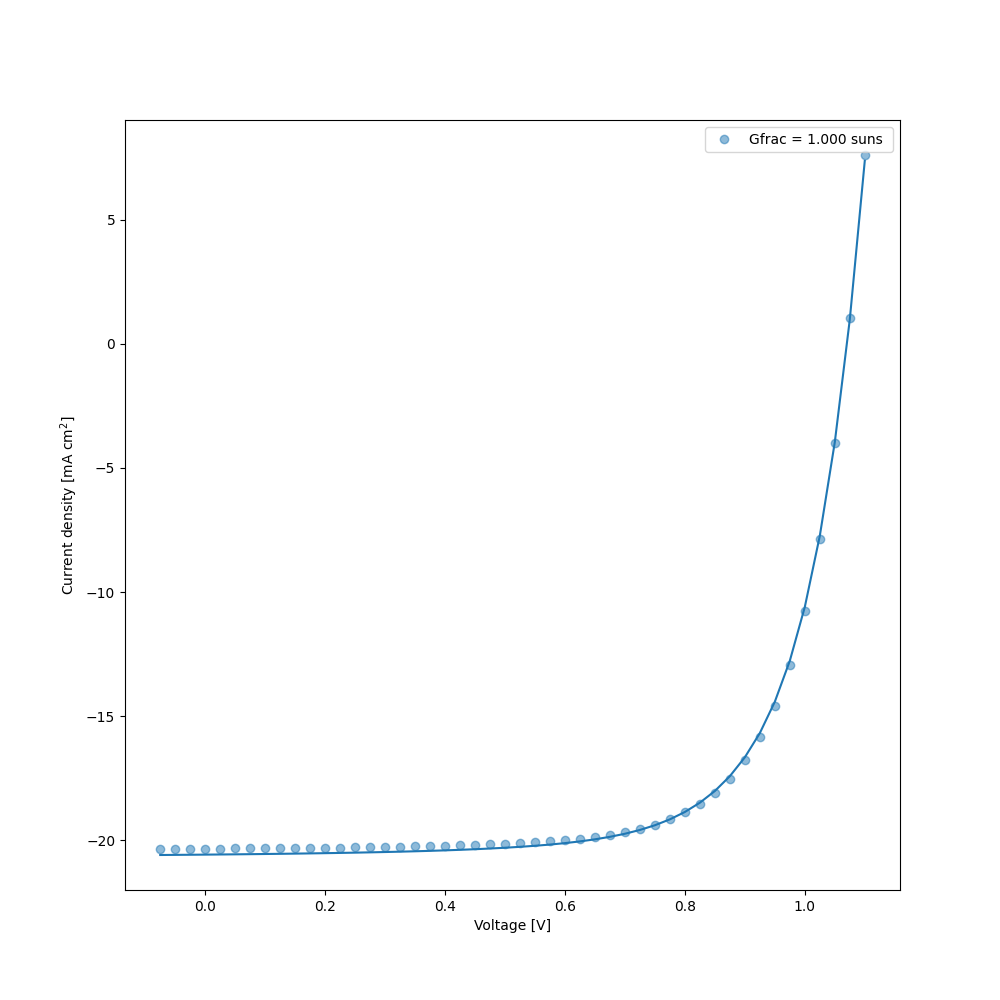

In [7]:
# Fit the datasets one by one
pf = [] # list to store the fit results
mo = MultiObjectiveOptimizer(params=params,res_dir=res_dir) # instantiate the optimizer
X_dimensions = ['Vext','Gfrac'] # dimensions of the X array
dda = Drift_diffusion_agent(path2simu=path2simu) # instantiate the agent

n_jobs = 3 
n_jobs_init = 3
n_yscale= 9 
n_initial_points = 30 
n_BO = 30 


target = {'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=1,dev_par_fname=dev_par_file),'target_name':'JV','data':{'X':X,'y':y,
            'X_dimensions':['Vext','Gfrac'],'X_units':['V','suns'],'y_dimension':'Current density','y_unit':r'$A/m²$'},'weight':1,'target_weight':1}
mo.targets = [target]
mo.params = params
mo.warmstart = 'None'


# kwargs_posterior = {'Nres':10,'N':3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':None,'show_points':True,'savefig':False,'figname':'param_posterior'+str(ii),'full_grid':True,'randomize':False}
kwargs_posterior = {'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':False}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_jobs_init=n_jobs_init,verbose=False,loss='linear',threshold=1000,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior)
pf.append(deepcopy(mo.params)) # collects optimized fitparameters
rrr = r['r'] # the results dict of the last optimizer.tell()


# plot the fit results
fit_results = []
kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Voltage [V]','xscale_type':'linear','y_scaling':1/10,'yaxis_label':'Current density [mA cm$^2$]','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(10,10),'savefig':False,'figname':'JV_fits_BO','figdir':'temp'}

for num,t in enumerate(mo.targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    dda.plot_fit_res(t,mo.params,'Vext',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = dda.get_param_dict(mo.params) # get fitparameters (and fixed ones) as dict
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict] # convert to list of lists

save_output = False
if save_output:
    # produce output excel file with data, fitparameters and FOMs
    fn_xlsx = 'fits_results_BO.xlsx'
    namecols = X_dimensions + ['Jexp','Jfit']
    # delete old file if it exists
    if os.path.exists(os.path.join(res_dir,fn_xlsx)):
        os.remove(os.path.join(res_dir,fn_xlsx))

    with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
        for i,t in enumerate(mo.targets):
            if 'target_name' in t.keys():
                tname = t['target_name']
            else: 
                tname = 'data'
            namecols = X_dimensions + [tname+'_exp',tname+'_fit']
            df = pd.DataFrame(fit_results[i],columns=namecols)
            df.to_excel(writer, sheet_name = tname+f'_{i}')
        
        df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
        df.to_excel(writer, sheet_name = f'params')
    


In [8]:
# Best fit parameters after BO
best_params = deepcopy(mo.params) # get the best parameters

for p in mo.params:
    p.startVal = p.val # reset the start values to the best ones before starting the gradient descent
    print(p.name,p.val)


Gehp 1.3e+28
Nc 1.5657351694170296e+26
Bulk_tr 1.0666304123157963e+19


## Gradient descent
Use curve fit to fine tune the parameters of the model starting from the best parameters found with the Bayesian optimization this help to give a better fit to the data without wasting time with longer Bayesian optimization runs for the fine tuning.
Note that using curve_fit alone without the Bayesian optimization is not recommended especially in high dimensional space and wide parameter ranges as it might get stick in local minima or take a long time to converge if the initial guess is not good.

In [9]:

kwargs_curve =  {'ftol':1e-8, 'xtol':1e-6, 'gtol': 1e-8, 'diff_step':0.001,'loss':'linear','maxfev':100}
print('Start curve fit')
try:
    rc = mo.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit


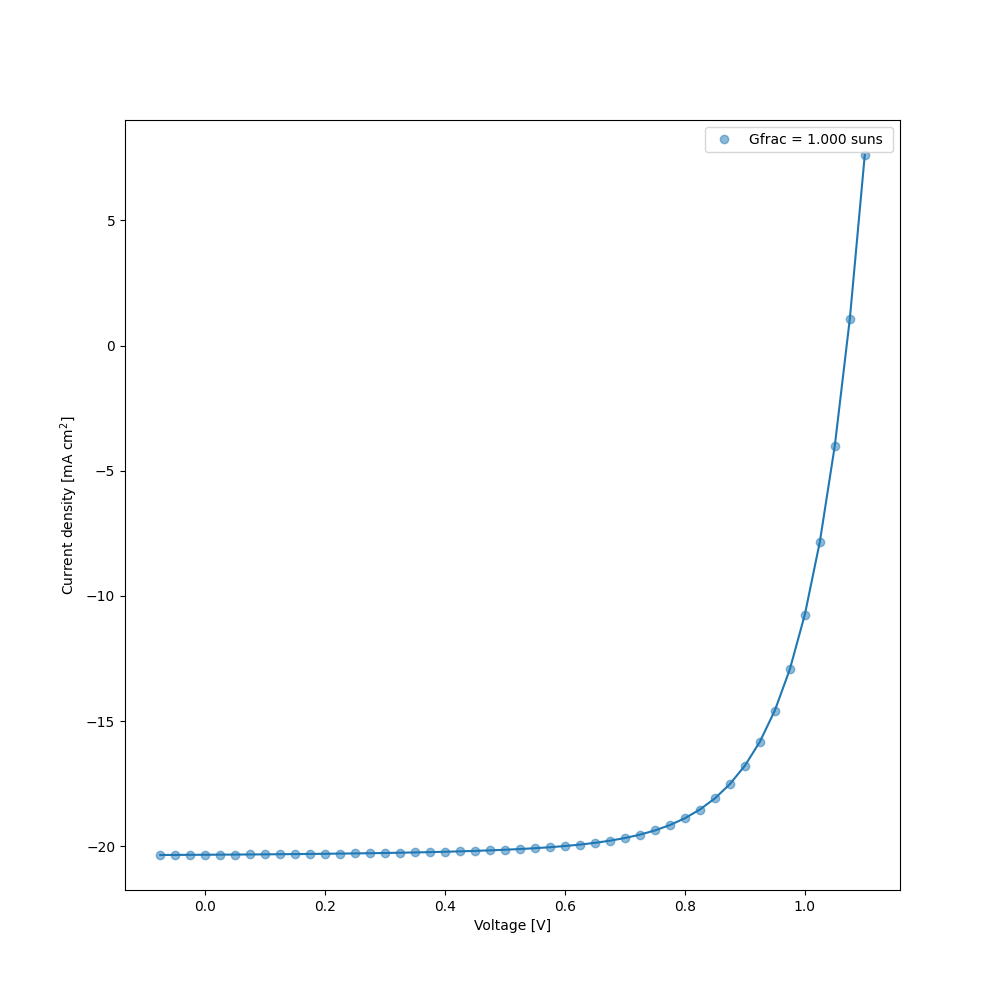

In [10]:
# plot the fit results
fit_results = []
kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Voltage [V]','xscale_type':'linear','y_scaling':1/10,'yaxis_label':'Current density [mA cm$^2$]','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(10,10),'savefig':False,'figname':'JV_fits_curve_fit','figdir':'temp'}

for num,t in enumerate(mo.targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    dda.plot_fit_res(t,mo.params,'Vext',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = dda.get_param_dict(mo.params) # get fitparameters (and fixed ones) as dict
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict] # convert to list of lists

save_output = False
if save_output:
    # produce output excel file with data, fitparameters and FOMs
    fn_xlsx = 'fits_results_curve_fit.xlsx'
    namecols = X_dimensions + ['Jexp','Jfit']
    # delete old file if it exists
    if os.path.exists(os.path.join(res_dir,fn_xlsx)):
        os.remove(os.path.join(res_dir,fn_xlsx))

    with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
        for i,t in enumerate(mo.targets):
            if 'target_name' in t.keys():
                tname = t['target_name']
            else: 
                tname = 'data'
            namecols = X_dimensions + [tname+'_exp',tname+'_fit']
            df = pd.DataFrame(fit_results[i],columns=namecols)
            df.to_excel(writer, sheet_name = tname+f'_{i}')
        
        df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
        df.to_excel(writer, sheet_name = f'params')
    


In [11]:
# Best fit parameters after curve fit
for p in mo.params:
    p.startVal = p.val # reset the start values to the best ones before starting the gradient descent
    print(p.name,p.val)

Gehp 1.2800365874021337e+28
Nc 1.6100544983118056e+26
Bulk_tr 2.609707289903318e+18


In [12]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *

Do_Cleaning = True # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('log',path2simu)
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(res_dir):
        shutil.rmtree(res_dir)

